In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from numpy import save,load


from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.optimizers import Adam,SGD
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101

from sklearn.metrics import roc_curve, auc,roc_auc_score

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb


from tqdm import tqdm
import cv2

from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate

np.random.seed(42)
%matplotlib inline

In [2]:
dataset_path="../input/casia-20-image-tampering-detection-dataset/CASIA2/"
path_original = 'Au/'
path_tampered = 'Tp/'
path_mask='CASIA 2 Groundtruth/'
total_original = os.listdir(dataset_path+path_original)
total_tampered = os.listdir(dataset_path+path_tampered)
total_mask=os.listdir(dataset_path+path_mask)

In [3]:
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+path_original+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+path_tampered+i)

In [4]:
total_tampered[0:5]

['Tp_D_NRN_M_N_nat00025_nat00028_11037.jpg',
 'Tp_S_NND_S_N_arc00012_arc00012_01111.tif',
 'Tp_S_NRN_S_N_art20038_art20038_01844.tif',
 'Tp_S_NRN_S_N_art00092_art00092_11809.jpg',
 'Tp_S_NNN_S_N_txt00060_txt00060_01282.tif']

In [5]:
total_tampered[0:5]

['Tp_D_NRN_M_N_nat00025_nat00028_11037.jpg',
 'Tp_S_NND_S_N_arc00012_arc00012_01111.tif',
 'Tp_S_NRN_S_N_art20038_art20038_01844.tif',
 'Tp_S_NRN_S_N_art00092_art00092_11809.jpg',
 'Tp_S_NNN_S_N_txt00060_txt00060_01282.tif']

In [6]:
def mask_pristine(path):
    img = Image.open(path).convert("RGB")
    img_shape=(np.array(img)).shape
    return np.ones((img_shape))*255

def plot_ground_truth_mask(image):
    fake=False
    if('Tp' in image):
        fake=True
        
    if fake:
        PATH=dataset_path+path_tampered+image
    else:
        PATH=dataset_path+path_original+image

    #PATH_mask=PATH[:-3]+'mask.png'
    PATH_mask=dataset_path+path_mask+image[:-4]+"_gt.png"
    
    img = Image.open(PATH).convert("RGB")
    
    try:
        mask_img=Image.open(PATH_mask).convert("RGB")
    except:
        mask_img=mask_pristine(PATH)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_title("Image")
    ax2.set_title("Ground Truth Mask")
    ax1.imshow(img)
    ax2.imshow(mask_img)

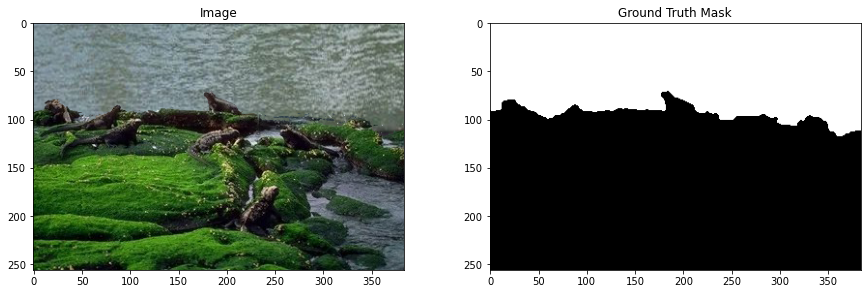

In [7]:
plot_ground_truth_mask("Tp_D_CND_M_N_ani00018_sec00096_00138.tif")

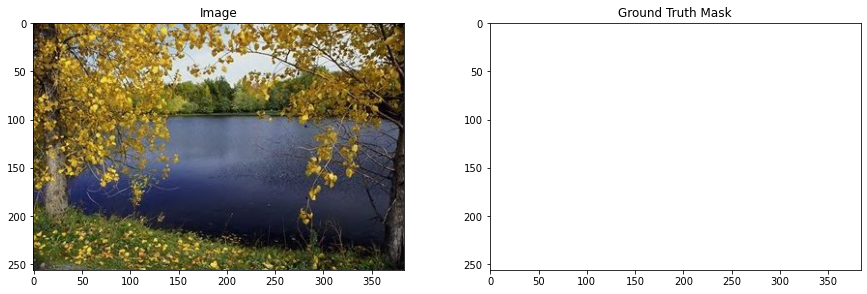

In [8]:
plot_ground_truth_mask(total_original[3])

In [11]:
output_path="./"

In [12]:
# os.rmdir(output_path+"resized_images/fake_masks/")
# os.rmdir(output_path+"resized_images/fake_images/")
# os.rmdir(output_path+"resized_images/pristine_images/")
# os.rmdir(output_path+"resized_images/")

In [13]:
if not os.path.exists(output_path+"resized_images/"):
    os.makedirs(output_path+"resized_images/fake_masks/")
    os.makedirs(output_path+"resized_images/fake_images/")
    os.makedirs(output_path+"resized_images/pristine_images/")
    height = 256
    width = 256
    p2=output_path+"resized_images/fake_masks/"
    p1=output_path+"resized_images/fake_images/"
    p3=output_path+"resized_images/pristine_images/"
    for fake_image in tqdm(total_tampered):
        try:
            img=Image.open(dataset_path+path_tampered + fake_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p1+fake_image)
        except:
            print("Encountered Invalid File : ",fake_image)
    
    for fake_mask in tqdm(total_mask):
        try:
            img=Image.open(dataset_path+path_mask + fake_mask).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p2+fake_mask)
        except:
            print("Invalid File : ", fake_mask)
    for pristine_image in tqdm(total_original):
        try:
            img=Image.open(dataset_path+path_original + pristine_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p3+pristine_image)
        except:
            print("Invalid File : " ,pristine_image)
        
else:
    print('images resized,path exists')

 60%|█████▉    | 3057/5125 [01:27<01:12, 28.60it/s]

Encountered Invalid File :  _list.txt


 67%|██████▋   | 3438/5125 [01:39<00:36, 46.26it/s]

Encountered Invalid File :  Thumbs.db


 66%|██████▋   | 4976/7492 [01:31<00:45, 54.70it/s]

Invalid File :  Thumbs.db


100%|██████████| 7492/7492 [02:17<00:00, 54.41it/s]


In [14]:
resized_fake_mask_path=output_path+"resized_images/fake_masks/"
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"

In [15]:
resized_fake_mask=os.listdir(resized_fake_mask_path)
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

In [16]:
#https://gist.github.com/cirocosta/33c758ad77e6e6531392
#error level analysis of an image
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff=""
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d=diff.load()
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff

In [17]:
ela_images_path=output_path+'ELA_IMAGES/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_images_path+i)
else:
    print('Images are already converted to ELA')

100%|██████████| 5123/5123 [08:04<00:00, 10.56it/s]


In [31]:
ELA_images_with_names = [i[:-4] for i in os.listdir('ELA_IMAGES/') ]
fake_mask_with_names = [i[:-7] for i in os.listdir(resized_fake_mask_path)]
print(ELA_images_with_names[0:5])
print(fake_mask_with_names[0:5])

['Tp_S_NRN_S_B_art00024_art00024_20088', 'Tp_S_NRN_S_N_arc20082_arc20082_02190', 'Tp_D_NRN_M_N_art00014_art00013_10270', 'Tp_S_NNN_S_N_sec00091_sec00091_00753', 'Tp_S_NNN_S_N_nat00044_nat00044_00658']
['Tp_S_NNN_S_N_nat00024_nat00024_20084', 'Tp_S_NNN_S_N_art10111_art10111_11562', 'Tp_S_CNN_M_N_art00053_art00053_10532', 'Tp_S_NRN_S_N_ind20007_ind20007_02267', 'Tp_D_NRN_M_N_nat10148_nat10159_12124']


In [29]:
common_images=list(set(ELA_images_with_names) & set(fake_mask_with_names))
len(common_images)

4981

In [47]:
temp_ela=[i for i in os.listdir('ELA_IMAGES/')]
temp_fake_mask=[i for i in os.listdir(resized_fake_mask_path)]
temp_fake_image=[i for i in os.listdir(resized_fake_image_path)]

ELA_images_with_path=[]
fake_mask_with_path=[]
fake_image_with_path=[]

for name in common_images:
    if(temp_ela.count(name + '.png')==1):
        ELA_images_with_path.append('ELA_IMAGES/'+name+'.png')
    elif(temp_ela.count(name + '.tif')==1):
        ELA_images_with_path.append('ELA_IMAGES/'+name+'.tif')
    elif(temp_ela.count(name + '.jpg')==1):
        ELA_images_with_path.append('ELA_IMAGES/'+name+'.jpg')
    
    if(temp_fake_mask.count(name+'_gt.png')==1):
        fake_mask_with_path.append(resized_fake_mask_path+name+'_gt.png')
    elif(temp_fake_mask.count(name+'_gt.tif')==1):
        fake_mask_with_path.append(resized_fake_mask_path+name+'_gt.tif')
    elif(temp_fake_mask.count(name+'_gt.jpg')==1):
        fake_mask_with_path.append(resized_fake_mask_path+name+'_gt.jpg')
    
    if(temp_fake_image.count(name+'.png')==1):
        fake_image_with_path.append(resized_fake_image_path+name+'.png')
    elif(temp_fake_image.count(name+'.tif')==1):
        fake_image_with_path.append(resized_fake_image_path+name+'.tif')
    elif(temp_fake_image.count(name+'.jpg')==1):
        fake_image_with_path.append(resized_fake_image_path+name+'.jpg')

In [48]:
ELA_images_with_path.sort()
fake_mask_with_path.sort()
fake_image_with_path.sort()

print(ELA_images_with_path[0:2])
print(fake_mask_with_path[0:2])
print(fake_image_with_path[0:2])

['ELA_IMAGES/Tp_D_CND_M_N_ani00018_sec00096_00138.tif', 'ELA_IMAGES/Tp_D_CND_M_N_art00076_art00077_10289.tif']
['./resized_images/fake_masks/Tp_D_CND_M_N_ani00018_sec00096_00138_gt.png', './resized_images/fake_masks/Tp_D_CND_M_N_art00076_art00077_10289_gt.png']
['./resized_images/fake_images/Tp_D_CND_M_N_ani00018_sec00096_00138.tif', './resized_images/fake_images/Tp_D_CND_M_N_art00076_art00077_10289.tif']


In [49]:
temp_set=set()

for i in temp_ela:
    temp_set.add(i[-4:])
print(temp_set)

{'.jpg', '.tif'}


In [50]:
total_tampered.sort()

In [51]:
def ela_and_mask(index):
   
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax1.set_title("tampered")
    ax2.set_title("ELA")
    ax3.set_title("Ground Truth Mask")
    
    ela_fake = Image.open(ELA_images_with_path[index])
    fake_mask = Image.open(fake_mask_with_path[index])
    tampered_image = Image.open(fake_image_with_path[index])
    ax1.imshow(tampered_image)
    ax2.imshow(ela_fake)
    ax3.imshow(fake_mask)

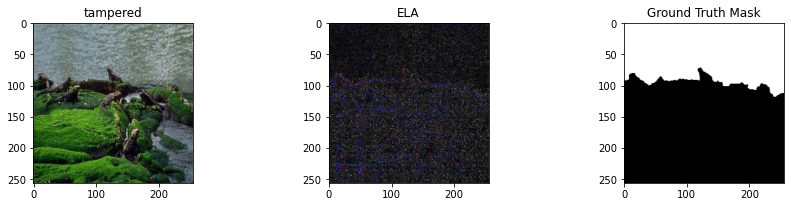

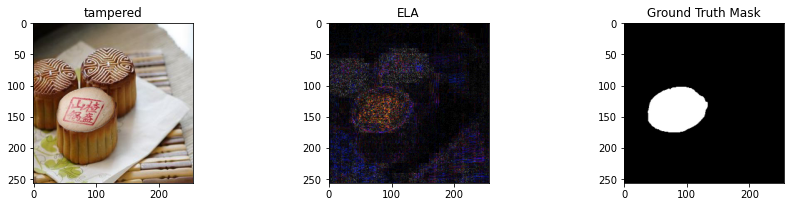

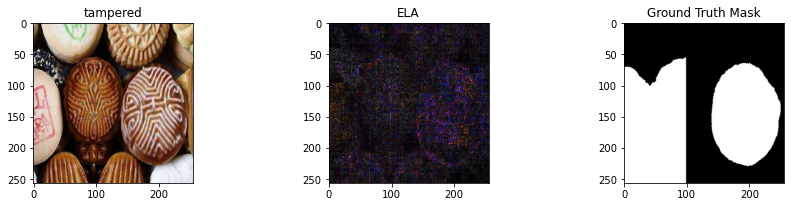

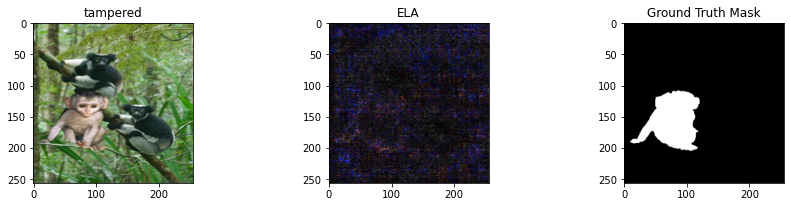

In [52]:
for i in range(4):
    ela_and_mask(i)

In [53]:
len(ELA_images_with_path),len(fake_mask_with_path)

(4981, 4981)

In [ ]:
# indices=np.random.randint(5000, size=500)
# print(indices)
# indices=list(indices)

In [56]:
small_ela_images_with_path=ELA_images_with_path[0:1200]
small_fake_mask_with_path=fake_mask_with_path[0:1200]
small_tampered_images_with_path=fake_image_with_path[0:1200]

In [57]:
small_ela_images_with_path[21],small_tampered_images_with_path[21],small_fake_mask_with_path[21]

('ELA_IMAGES/Tp_D_CNN_M_N_sec10110_sec10101_10298.tif',
 './resized_images/fake_images/Tp_D_CNN_M_N_sec10110_sec10101_10298.tif',
 './resized_images/fake_masks/Tp_D_CNN_M_N_sec10110_sec10101_10298_gt.png')

In [58]:
X_train, X_val, Y_train, Y_val = train_test_split(small_ela_images_with_path,
                                                  small_fake_mask_with_path , 
                                                  test_size=0.1,
                                                  random_state=42)

In [ ]:
# train_data = [i for i in X_train]
# mask_data = [i for i in Y_train]

In [59]:
## save all the train and validation files into a text file using pickle
import pickle
with open("X_train.txt", "wb") as f:   #Pickling
    pickle.dump(X_train, f) 

## save all the converted text into a text file using pickle
with open("Y_train.txt", "wb") as f:   #Pickling
    pickle.dump(Y_train, f) 
    
with open("X_val.txt", "wb") as f:   #Pickling
    pickle.dump(X_val, f) 

## save all the converted text into a text file using pickle
with open("Y_val.txt", "wb") as f:   #Pickling
    pickle.dump(Y_val, f) 

In [60]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return K.mean((2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [61]:
def LoadImages(batch):
    return np.array([resize(imread(file_name), (256, 256, 3)) for file_name in batch])

def loadImagesBatchwise(X_train,Y_train, batch_size):
    train_image_files=X_train
    train_mask_files=Y_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            Y = LoadImages(train_mask_files[batch_start:limit])
            Y=  rgb2gray(Y)
            Y= Y.reshape(-1,256,256,1)
            Y=(Y>=0.5)*1.0
#             print(Y)
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size

(256, 256, 3) (1, 256, 256, 1)
[0. 1.]


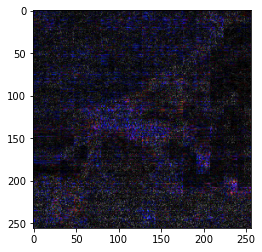

In [62]:
temp=LoadImages(Y_train[0:1])
# plt.imshow(temp[0])
var=rgb2gray(temp)
var=var.reshape(-1,256,256,1)
print(temp[0].shape,var.shape)
var=(var>=0.5)*1.0
plt.imshow(var[0],cmap='gray')
var2=var.reshape(1,-1)
unique, counts = np.unique(var2, return_counts=True)
temp2=LoadImages(X_train[0:1])
plt.imshow(temp2[0],cmap='gray')
print(np.asarray((unique)))

In [68]:
from math import ceil

batch_size=16
num_training_samples=len(X_train)
num_validation_samples=len(X_val)
# steps = ceil(len(X_train)//batch_size)
num_epochs=30
if not os.path.exists('./model_checkpoints'):
    os.makedirs('./model_checkpoints')
# define callbacks for learning rate scheduling and best checkpoints saving
filepath = './model_checkpoints/image_tampering_ela.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='loss',save_best_only=True,verbose=1)

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=7,verbose=1,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.22, patience = 3, verbose = 1, min_delta = 0.0001)

In [64]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-zev74bho
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-zev74bho
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 773 kB/s eta 0:00:01
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33792 sha256=ec5d50f50120b6f587888fdf90210c33615008c66b5fc3c0d05072e13bad51c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-axclxuhp/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
Note: you may need to restart the kernel to use updated packages.


In [65]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [66]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [69]:
# https://github.com/qubvel/segmentation_models
from segmentation_models import Unet
model = Unet('resnet101', input_shape=(256, 256, 3),classes=1, activation='sigmoid',encoder_weights='imagenet')


model.compile(optimizer=optimizers.Adam(), loss=dice_coef_loss, metrics=[dice_coef,iou_score])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

In [ ]:
dir

In [ ]:
ls

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# hello = reshaped_image_data2.flatten()
#         #y_to = keras.utils.to_categorical(y_to,num_classes=2)
#     print(reshaped_image_data2.shape)
#     #print(hello[hello==3].shape)
#     print("Number of classes",np.unique(hello))
#     class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)

In [70]:
results=model.fit(loadImagesBatchwise(X_train,Y_train,batch_size),
                  steps_per_epoch=(num_training_samples // batch_size), 
                  epochs=num_epochs,
                  validation_data=loadImagesBatchwise(X_val,Y_val,batch_size),
                  validation_steps=num_validation_samples//batch_size,
                  verbose=1,
                  callbacks=[early_stop,reduce_lr,checkpoint])


Epoch 1/30
67/67 [==============================] - 45s 454ms/step - loss: 0.0860 - dice_coef: 0.9140 - iou_score: 0.1208 - val_loss: 0.1017 - val_dice_coef: 0.8983 - val_iou_score: 0.0031

Epoch 00001: loss improved from inf to 0.07827, saving model to ./model_checkpoints/image_tampering_ela.h5
Epoch 2/30
67/67 [==============================] - 30s 436ms/step - loss: 0.0723 - dice_coef: 0.9269 - iou_score: 0.1312 - val_loss: 0.0914 - val_dice_coef: 0.9086 - val_iou_score: 0.1083

Epoch 00002: loss improved from 0.07827 to 0.07200, saving model to ./model_checkpoints/image_tampering_ela.h5
Epoch 3/30
67/67 [==============================] - 29s 432ms/step - loss: 0.0682 - dice_coef: 0.9311 - iou_score: 0.1505 - val_loss: 0.0896 - val_dice_coef: 0.9104 - val_iou_score: 0.1015

Epoch 00003: loss improved from 0.07200 to 0.07005, saving model to ./model_checkpoints/image_tampering_ela.h5
Epoch 4/30
67/67 [==============================] - 29s 435ms/step - loss: 0.0687 - dice_coef: 0.9304

Epoch 29/30
67/67 [==============================] - 28s 421ms/step - loss: 0.0301 - dice_coef: 0.9698 - iou_score: 0.5072 - val_loss: 0.0806 - val_dice_coef: 0.9194 - val_iou_score: 0.2472

Epoch 00029: loss improved from 0.03509 to 0.03368, saving model to ./model_checkpoints/image_tampering_ela.h5
Epoch 30/30
67/67 [==============================] - 28s 419ms/step - loss: 0.0295 - dice_coef: 0.9705 - iou_score: 0.5096 - val_loss: 0.0809 - val_dice_coef: 0.9191 - val_iou_score: 0.2606

Epoch 00030: loss improved from 0.03368 to 0.03160, saving model to ./model_checkpoints/image_tampering_ela.h5


In [71]:
model.save('./ela_model.h5')
model.save('/ela_model_0.hdf5')

In [72]:
def plotAccuracyAndLoss(history):
#     plt.plot(history.history['mse'])
    y = history.history['loss']
    y2 = history.history['dice_coef']
    y3 = history.history['val_loss']
#     y4 = history.history['val_metric']
    plt.plot(y)
    plt.plot(y2)
    plt.plot(y3)
#     plt.plot(y4)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
    plt.legend(['loss','dice_coeff','val_loss'],loc='upper left')
#     plt.savefig('./')
    plt.show()

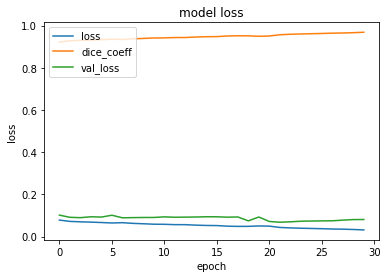

In [73]:
plotAccuracyAndLoss(results)

In [74]:
test_images=LoadImages(small_ela_images_with_path)
predicted=model.predict(test_images)

In [93]:
def plot_predicted_images(index):
    """Plots the predicted masks of tampered images"""
    #ret, bw_img = cv2.threshold((predicted[index]*255),127,255,cv2.THRESH_BINARY)
    img=gray2rgb(predicted[index])
    plt.imsave('pred_mask.png',img)
    im_gray = cv2.imread('pred_mask.png')
#     (thresh, im_bw) = cv2.threshold(im_gray, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    im_bw=(rgb2gray(img)>=0.14)*1.0
#     #imshow(im_bw)
#     im_bw=(predicted[index]>=0.1)*1.0
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(441)
    ax2 = fig.add_subplot(442)
    ax3 = fig.add_subplot(443)
    ax4 = fig.add_subplot(444)
    
    ax1.set_title("actual_image")
    ax2.set_title("actual_mask")
    ax3.set_title("predicted_mask")
    ax4.set_title("binary_predicted_mask")
    actual_img = imread(small_tampered_images_with_path[index])

    actual_mask = imread(small_fake_mask_with_path[index])
    #predicted_mask = imread(predicted[0])

    
    ax1.imshow(actual_img)
    ax2.imshow(actual_mask)
    ax3.imshow(predicted[index],cmap='gray')
    ax4.imshow(im_bw,cmap='gray')

In [ ]:
# var2=(predicted[0]>=0.1)
# unique, counts = np.unique(var2, return_counts=True)
# print(np.asarray((unique, counts)).T)
# plt.imshow(var2)

In [ ]:
# temp=LoadImages(Y_train[0:1])
# var=rgb2gray(temp)
# var=var.reshape(256,256,1)
# var=(var>=0.5)*1.0
# temp2=predicted[0]
# temp2 = temp2.astype('float32')
# var = var.astype('float32')
# print(var.shape,temp2.shape)
# print(K.eval(dice_coef(var,temp2)))

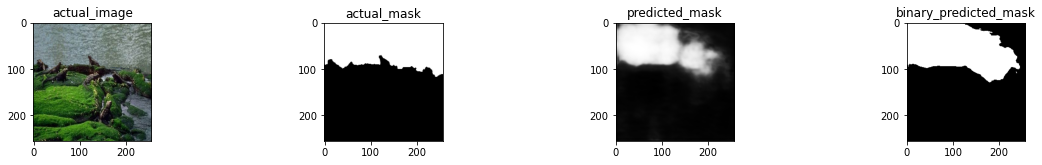

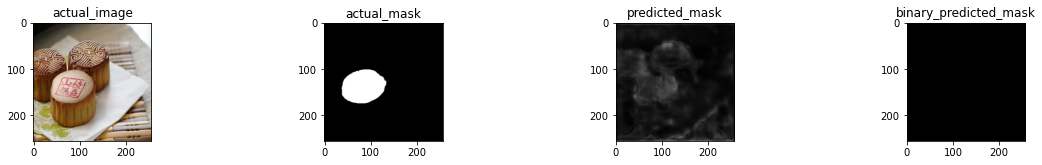

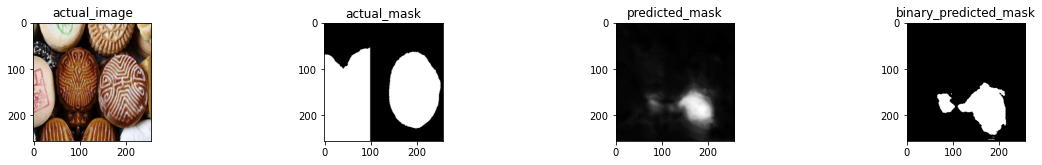

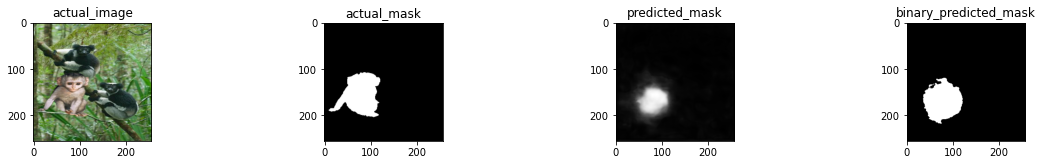

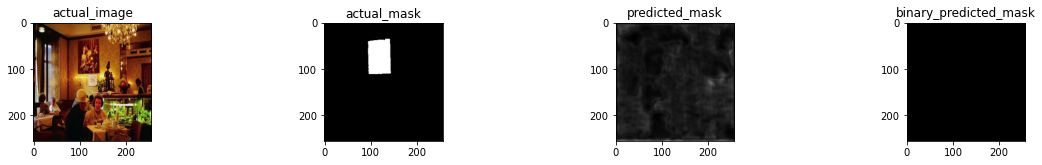

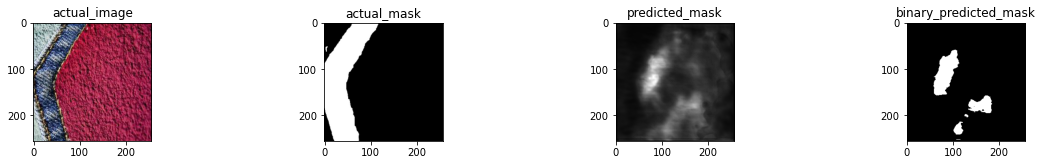

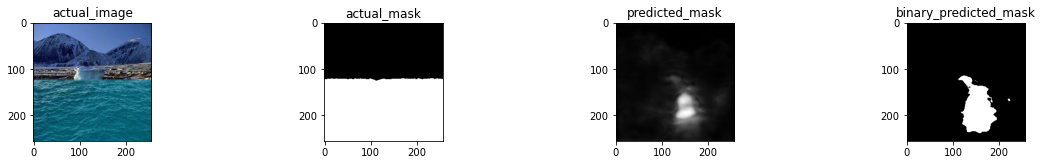

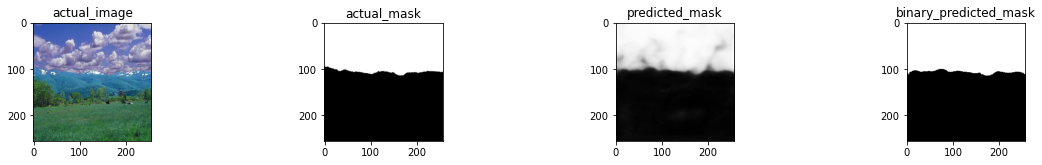

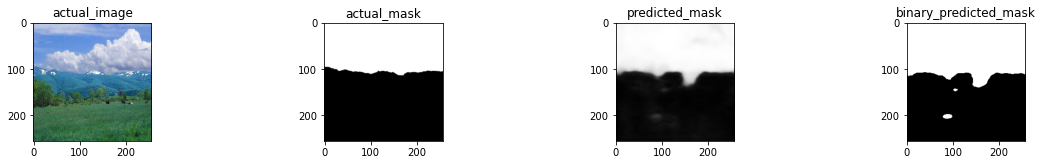

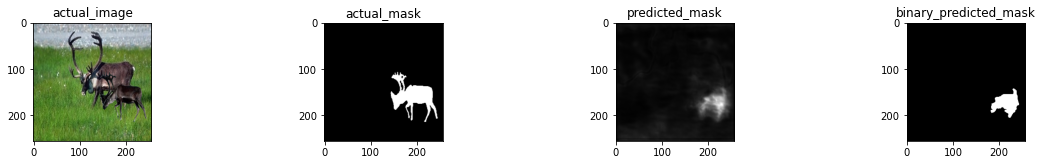

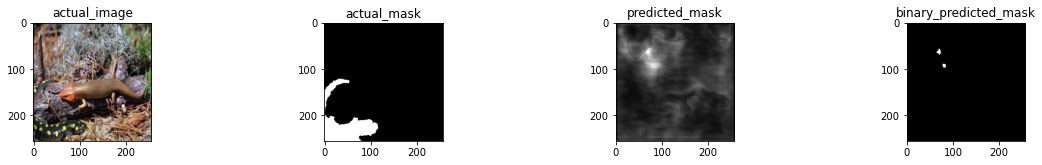

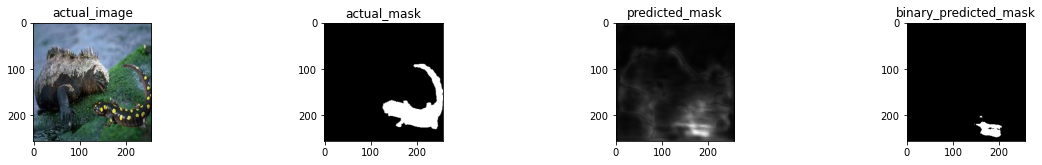

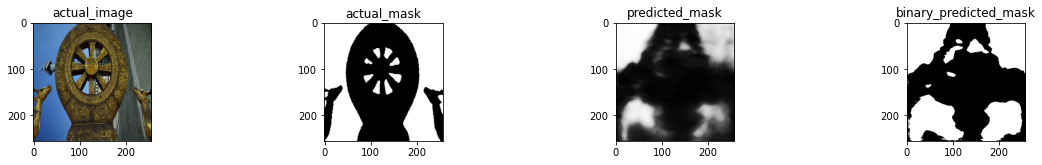

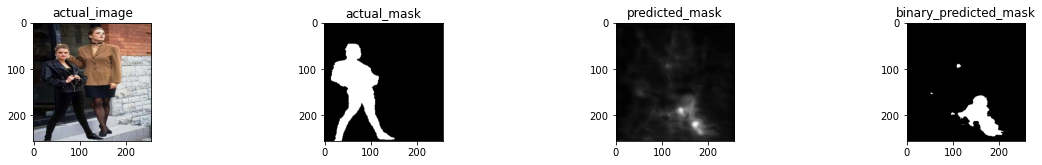

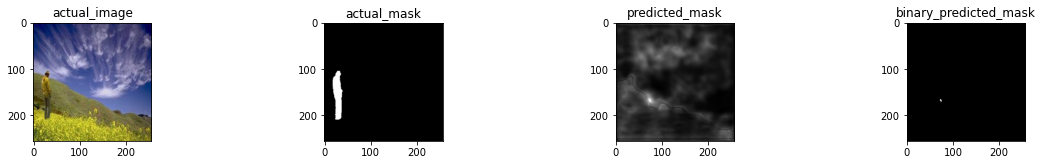

In [94]:
for i in range(15):
    plot_predicted_images(i)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_for_json.h5")
print("Saved model to disk")